## Timeline
**Start of Project:** 04.11.2019 
**Submission of Project Results:** 27.11.2019

**Phases:** 
1. Week (06.11 - 12.11): Preprocessing 
2. Week (13.11 - 19.11): Iterate & Evaluate the Models 
3. Week (20.11 - 26.11): Writing the Report

## Responsibilities
- Liste mit Begründungen für Auswahl der Feature (Feature | Begründung) - Jannik
- Preprocessing: 
  - Neighbourhood_cleansed (One-hot) (& PLZ Gibt es genug Beispiele prüfen?)- Daniel 
  - Property_type (One-hot) - Jannik 
  - Room_type (One-hot) - Jannik
  - Accomodates - Caro
  - Bathrooms (Maybe) - Caro
  - Bedrooms - Fritz
  - Amenities - Jakob
  - Beds - Fritz
  - Bed_type (One-hot) - Fritz

- Juli Datensatz fürs Preprocessing

# Airbnb Price Prediction

## Goal
The goal of our data mining project is to predict prices for new Airbnb listings in Munich. To achieve this, we will train a regression model on existing Airbnb data from www.insideairbnb.com.

## Import libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from math import sqrt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, SelectFwe
from collections import Counter
import seaborn as sns
import numpy as np
#import geopandas as gpd #requires install via conda/pip
#import geoplot as glt #requires install via conda/pip
#from shapely.geometry import Point, polygon



## Load the data

In [57]:
#Load dataset
munich = pd.read_csv('Data/listings_Munich_July.csv')
#Create copy of dataset with original values
munich_initialcopy = munich.copy()

C:\Users\fn8j\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
# drop all colums except the ones that we are using 
munich = munich.loc[:, munich.columns.intersection(['neighbourhood_cleansed', 'property_type', 
                                                    'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                                                    'beds', 'bed_type', 'price', 'amenities', 
                                                    'extra_people','guests_included', 'longitude', 'latitude'])]

## Understand & Preprocess the data

In [59]:
munich_initialcopy
#get list of columnnames
list(munich_initialcopy.columns.values)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


### Neighbourhoods 

In [60]:
## show amount of entries per neighbourhood
# understand feature neighbourhoods_cleansed
print(munich['neighbourhood_cleansed'].value_counts())

Ludwigsvorstadt-Isarvorstadt                              1077
Maxvorstadt                                               1000
Schwabing-West                                             735
Neuhausen-Nymphenburg                                      702
Au-Haidhausen                                              686
Schwabing-Freimann                                         589
Bogenhausen                                                471
Milbertshofen-Am Hart                                      428
Sendling                                                   427
Schwanthalerhöhe                                           409
Ramersdorf-Perlach                                         368
Sendling-Westpark                                          361
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln     359
Laim                                                       353
Obergiesing                                                346
Untergiesing-Harlaching                                

In [61]:
## show amount of entries per zipcode
print(munich_initialcopy['zipcode'].value_counts())

80469           418
80339           342
80337           329
81541           272
80333           217
80636           205
81373           199
80799           196
80798           192
81371           192
80336           181
80796           179
81667           174
81543           173
80687           173
80809           166
80335           163
80797           162
80807           155
80634           152
81369           152
81539           151
81379           149
80804           142
81669           118
80637           114
80538           113
80802           112
81677           106
80803           100
               ... 
80995.0          10
80937.0          10
80539.0           9
80638.0           9
81249.0           9
81735.0           9
81545.0           9
81243.0           8
80999.0           5
81475.0           5
85540             4
80933.0           3
82049.0           2
85757             2
80799\n80799      1
12459             1
81823             1
München           1
80679.0           1


In [62]:
## show zipcodes per neighbourhood
# tbd

#one-hot encoding


### Price

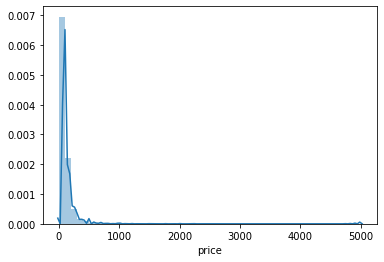

In [63]:
# convert column price to float values without leading $ sign
munich['price'] = munich['price'].replace( '[\$,)]','', regex=True ).astype(float)

#examine distribution
sns.distplot(munich['price'])
plt.show()



Since the feature 'price' describes a standard price of the appartment and is determined by the host himself, it can include the fee for an arbitrary number of people. The number of people included in the 'price' feature is described in the feature 'guests_included'. For every additional guest that is going to stay in the appartment, an additional fee is raised. This fee is described in the feature 'extra_people'. Because the standard price can differ a lot depending on the guests included, we decided to compute a feature 'max_price' which describes the maximum price one has to pay if all possible accommodates would stay in the appartment.

In [64]:
# convert column extra people to float values without leading $ sign
munich['extra_people'] = munich['extra_people'].replace( '[\$,)]','', regex=True ).astype(float)

#create variable accounting for maximium price of each listing
for i, row in munich.iterrows():
    if row.guests_included < row.accommodates:
        munich.loc[i, 'max_price'] = row.price + (row.accommodates - row.guests_included) * row.extra_people
    else:
        munich.loc[i, 'max_price'] = row.price
            
print(munich['max_price'].describe())
print()
print(munich['price'].describe())   

munich = munich.drop(columns = ['guests_included', 'extra_people'])                                     

count    10238.000000
mean       130.870189
std        144.640601
min          8.000000
25%         60.000000
50%         94.000000
75%        150.000000
max       5000.000000
Name: max_price, dtype: float64

count    10238.000000
mean       109.059094
std        123.248284
min          8.000000
25%         50.000000
50%         80.000000
75%        120.000000
max       5000.000000
Name: price, dtype: float64


The prices of 167 listings are more than 3 Standard Deviations above the mean. Therefore, these data points are excluded. Afterwards, the distribution more closely resembles a normal distribution. 

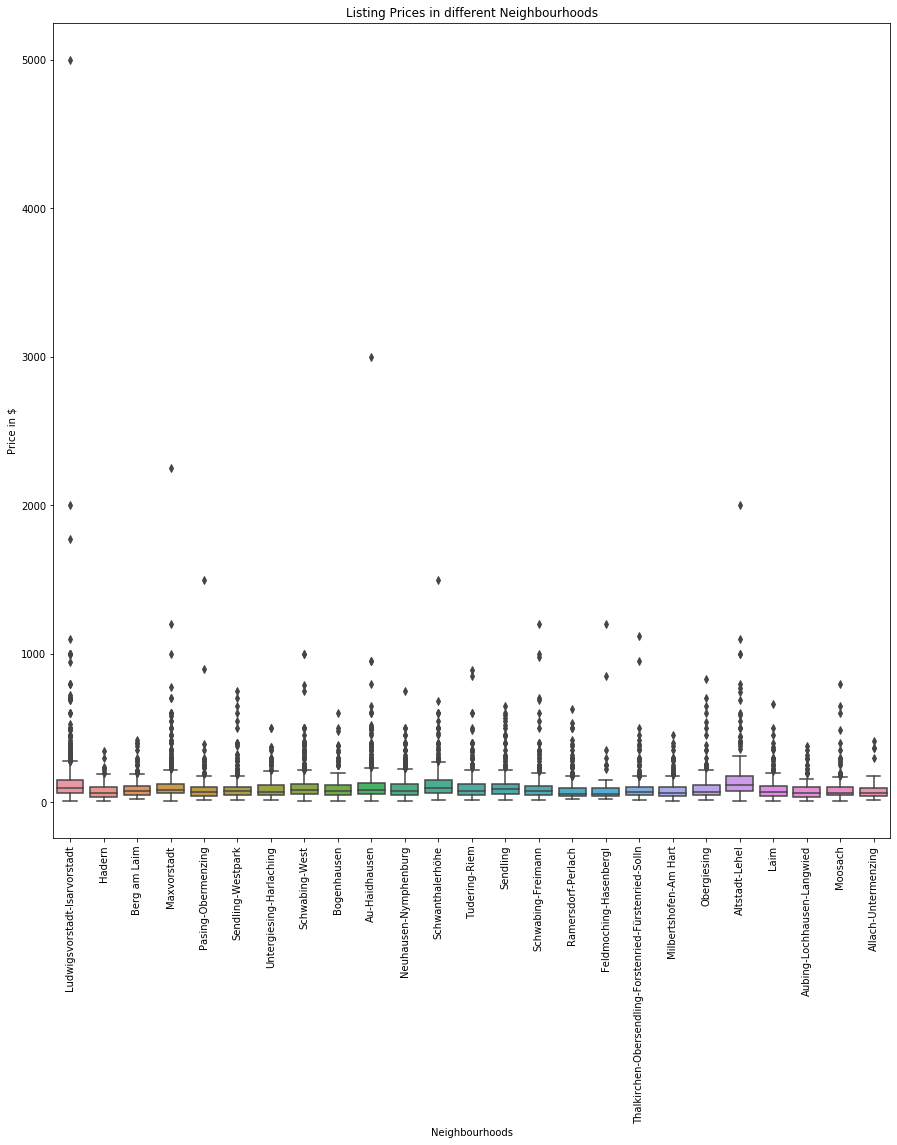

In [65]:
#Visualizing

fig,ax = plt.subplots(figsize = (15, 15), )
sns.boxplot(x = munich['neighbourhood_cleansed'], y = munich['price'], ax=ax)
plt.xticks(rotation=90)
plt.xlabel('Neighbourhoods')
plt.ylabel('Price in $')
plt.title('Listing Prices in different Neighbourhoods')
plt.show()

In [11]:
#read shapefile of Bavaria\n",
munich_sh = 'Data//Geodata/gmd_ex.shp'
map_df = gpd.read_file(munich_sh)

#Create point for every listing
geometry = [Point(xy) for xy in zip (munich['longitude'], munich['latitude'])]
munich = munich.drop(columns = ['longitude', 'latitude'])
crs = {'init': 'epsg:4326'} # crs-data tells geopandas how the data relate to points in the real worlds (e.g. latitude and longitude)
map_df = map_df.to_crs(epsg=4326) #convert given shapefile to latitude and longitude-crs

#create Geo-DataFrame with Points and Prices for each listing
geo_df = gpd.GeoDataFrame(munich['price'], crs = crs, geometry = geometry)

#compute distance to Marienplatz as a proxy for the city centre
geo_df['distance_centre'] = geo_df.distance(Point(11.576006, 48.137079))

#add feature to DataFrame and create a Geopandas-object for plotting
munich['distance_centre'] = geo_df['distance_centre']
point_marienplatz = gpd.GeoSeries(Point(11.576006, 48.137079),crs=crs)

#plot the data
ax = map_df[(map_df['BEZ_GEM'] == 'MÃ¼nchen')].plot(figsize=(20, 10), alpha=0.7, color = 'grey')
plt.title('Listing Prices (in $) in Munich', fontsize=30)
glt.pointplot(geo_df, ax=ax, hue=munich['price'], legend=True, legend_kwargs={'orientation': 'horizontal'})
#glt.pointplot(geo_df, ax=ax, hue=munich['distance_centre'], legend=True, legend_kwargs={'orientation': 'horizontal'})
point_marienplatz.plot(ax=ax, markersize= 60,  color = 'red') #plot location of the Marienplatz




NameError: name 'gpd' is not defined

In [12]:
 #discretise distance_centre
discretiser = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal')
munich['distance_centre'] = discretiser.fit_transform(munich['distance_centre'].values.reshape(-1, 1))

#plot relationship between price and distance to city centre
distance_price = munich[['distance_centre', 'price']].groupby('distance_centre').mean()
print(distance_price.plot())

KeyError: 'distance_centre'

These visuals suggest that there is not only a significant difference in the median prices in the different neighbourhoods of Munich, but also that more expensive listings appear to be clustered in and around the centre of the city.

The further away a listing is from the centre of the city (Marienplatz), the less expensive it is on average. This describtive analysis warrants further examination using inference methods.

### Bedrooms

0.0     1023
1.0     7683
2.0     1157
3.0      288
4.0       57
5.0        4
6.0        2
7.0        1
8.0        6
10.0       1
20.0       1
25.0       1
Name: bedrooms, dtype: int64
                price
bedrooms             
0.0         92.608016
1.0         94.791618
2.0        171.490925
3.0        243.763889
4.0        325.473684
5.0        264.750000
6.0       1450.000000
7.0        400.000000
8.0         74.833333
10.0        30.000000
20.0        30.000000
25.0       115.000000
AxesSubplot(0.125,0.125;0.775x0.755)


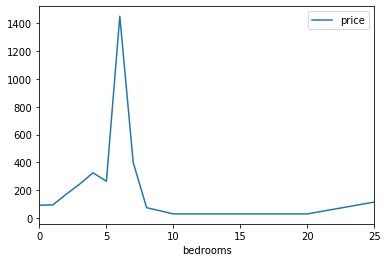

In [66]:
# Fritz: understand feature bedrooms 
# check the value count
print(munich['bedrooms'].value_counts().sort_index())

# analyze the effect of bedroom number on price
bedrooms_price = munich[['bedrooms', 'price']].groupby('bedrooms').mean()

# print the mean values for number of bedrooms
print(bedrooms_price)

# print the plot
print(bedrooms_price.plot())

# replace zero bedrooms with one bedroom
munich.loc[munich.bedrooms == 0.0, 'bedrooms'] = 1.0

One can see that most listings have one or two bedrooms. In 1023 cases there seems to be no bedroom. This value is set by Airbnb landlords if there is not seperated bedroom (e.g. a one room apartment or when accommodating in the living room). It needs to be evaluated how well several regression models can handle this encoding.

The listings with 25, 20 and 10 bedrooms are hostels. As there only exist 16 listings with more than four bedrooms, it might make sense to drop those as these are extreme outliers. We can later on specify that our model is only able to predict price for new listings with less than five bedrooms.

There is a clear linear dependency between number of bedrooms and price if one only looks at listings with one to four bedrooms. The difference in prices between zero and one bedroom is almost not present. Thus, it makes sense to combine those listings. Every listing with zero bedrooms will be changed to one bedroom. This also needs to be applied when inferring later on.

### Beds

0.0       48
1.0     6608
2.0     2455
3.0      575
4.0      279
5.0       98
6.0       83
7.0       28
8.0       31
9.0        1
10.0       3
12.0       1
14.0       1
15.0       1
16.0      10
18.0       1
20.0       1
30.0       1
50.0       1
Name: beds, dtype: int64
           price
beds            
1.0    88.584135
2.0   123.750713
3.0   173.624348
4.0   195.706093
5.0   234.469388
6.0   295.493976
7.0   303.464286
8.0   201.193548
9.0   149.000000
10.0  316.666667
12.0  800.000000
14.0  399.000000
15.0  900.000000
16.0  107.800000
18.0  199.000000
20.0   30.000000
30.0   30.000000
50.0  115.000000
AxesSubplot(0.125,0.125;0.775x0.755)


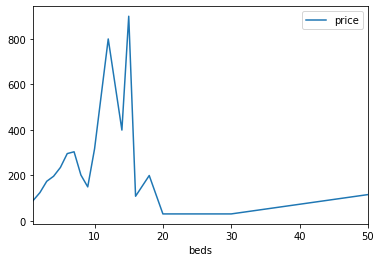

In [67]:
# Fritz: understand feature beds
# check the value count
print(munich['beds'].value_counts().sort_index())

# replace zero beds with one bed
munich.loc[munich.beds == 0.0, 'beds'] = 1.0

# analyze the effect of number of beds on price
beds_price = munich[['beds', 'price']].groupby('beds').mean()

# print the mean values for number of beds
print(beds_price)

# print the plot
print(beds_price.plot())

Here one can see a similar situation as with the number of bedrooms. Most listings have one or two beds. In 48 cases Airbnb landlords set the number of beds to zero. A manual check of some listings showed that beds are actually present and listings were not created correctly. Thus, listings with zero beds will not be considered in the training.

Only 10 listings offer 9 or more beds. These might be dropped as well like examples with five ore more bedrooms.

There is a close to linear dependecy between the number of beds and the price if one only looks at examples with less than six beds. The price seems to decrease if there are more than six beds. It might make sense to also drop listings with seven or eight beds.

### Bed_type

Real Bed         9728
Pull-out Sofa     343
Couch              79
Futon              61
Airbed             27
Name: bed_type, dtype: int64
                    price
bed_type                 
Airbed          94.851852
Couch           78.265823
Futon           78.885246
Pull-out Sofa   83.367347
Real Bed       110.443668
AxesSubplot(0.125,0.125;0.775x0.755)


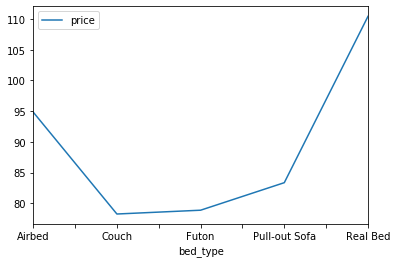

In [68]:
# Fritz: understand feature bed_type
# check the value count
print(munich['bed_type'].value_counts())

# analyze the effect of bed_type on price
bed_type_price = munich[['bed_type', 'price']].groupby('bed_type').mean()

# print the mean values for bed_types
print(bed_type_price)

# print the plot
print(bed_type_price.plot())

# ordinal encoding
# create replace map
replace_map = {'bed_type': {'Couch': 1, 'Futon': 1, 'Pull-out Sofa': 1, 'Airbed': 2, 'Real Bed': 3}}

# replace categorical values using replace map
munich = munich.replace(replace_map)

One can see that real beds are offered in the great majority (95%) of all listings. Pull-out sofas occur in about 3% while listings with bed types couch, futon and airbed are not really present in the dataset.

It is interesting to see that prices of listings with airbeds are significantly higher compared to couch, futon or pull-out sofa. The prices for real bed listings are the highest which is not surprising. With respect to the dependencies, it makes sense to do an ordnial encoding of this categorical feature. Couch, futon and pull-out-sofa will be converted to value 1, airbed to value 2 and real bed to value 3.

### Amenities

As they potentially provide significant value to the customers of Airbnb (e.g. kitchen, internet), amenities could easily affect the price of a given listing and are therefore included in the analysis.

First, as the amenities in the data are given as a list of strings per listing, we have to split the data in order to analyse which specific amenities might be useful to the analysis.

In [69]:
all_amenities = list()  #create list of all individual amenities
for amenities in munich['amenities']:
    for amenity in amenities.split("{")[1].split("}")[0].split(","):
        all_amenities.append(amenity.replace('"', ''))
#all_amenities_set = set(all_amenities)
Counter(all_amenities).most_common(50)

[('Heating', 9709),
 ('Wifi', 9581),
 ('Essentials', 9314),
 ('Kitchen', 9306),
 ('Washer', 7907),
 ('Smoke detector', 7127),
 ('Hair dryer', 6978),
 ('Hangers', 6748),
 ('Laptop friendly workspace', 6408),
 ('TV', 6300),
 ('Iron', 5990),
 ('Shampoo', 5617),
 ('Hot water', 4657),
 ('Elevator', 4490),
 ('Dryer', 3517),
 ('Lock on bedroom door', 3460),
 ('Refrigerator', 2983),
 ('Dishes and silverware', 2909),
 ('Internet', 2905),
 ('Host greets you', 2797),
 ('Bed linens', 2765),
 ('Stove', 2742),
 ('Cooking basics', 2718),
 ('Family/kid friendly', 2500),
 ('Cable TV', 2458),
 ('Oven', 2358),
 ('Buzzer/wireless intercom', 2217),
 ('First aid kit', 2200),
 ('Coffee maker', 2127),
 ('Dishwasher', 1988),
 ('Free parking on premises', 1933),
 ('Free street parking', 1864),
 ('Patio or balcony', 1706),
 ('Private entrance', 1649),
 ('Fire extinguisher', 1619),
 ('No stairs or steps to enter', 1529),
 ('Carbon monoxide detector', 1496),
 ('Extra pillows and blankets', 1467),
 ('Luggage dropof

We now can filter out those amenities which conceivably affect the price and which are occuring often enough in order to be regarded as significant.

We extract these features into a list and create new variables for each one to perfom One-Hot-Encoding.

In [70]:
relevant_amenities = ['Wifi', 'Internet', 'TV', 'Kitchen', 'Heating', 'Washer', 'Patio or balcony', 
                      'Breakfast', 'Elevator','24-hour check-in', 'Pool', 
                      'Private entrance','Dishwasher', 'Bed linens','Smoking allowed'] 

for element in relevant_amenities: #create dummy variables
    munich[element.lower()] = 0
    
for row in munich.itertuples(): #can take a moment
    for element in relevant_amenities:
        if element in row.amenities:
            munich.loc[row.Index, element.lower()] = 1
            
munich = munich.drop(columns = 'amenities')

In [71]:
for amenity in relevant_amenities: #analyse features with regard to districts
    print(pd.crosstab(munich['neighbourhood_cleansed'], munich[amenity.lower()]))
    print() 

wifi                                                 0     1
neighbourhood_cleansed                                      
Allach-Untermenzing                                  1    60
Altstadt-Lehel                                      19   311
Au-Haidhausen                                       37   649
Aubing-Lochhausen-Langwied                           4    78
Berg am Laim                                        17   194
Bogenhausen                                         36   435
Feldmoching-Hasenbergl                               3    94
Hadern                                               8   116
Laim                                                27   326
Ludwigsvorstadt-Isarvorstadt                        71  1006
Maxvorstadt                                         59   941
Milbertshofen-Am Hart                               33   395
Moosach                                             10   183
Neuhausen-Nymphenburg                               46   656
Obergiesing             

dishwasher                                            0    1
neighbourhood_cleansed                                      
Allach-Untermenzing                                  46   15
Altstadt-Lehel                                      247   83
Au-Haidhausen                                       542  144
Aubing-Lochhausen-Langwied                           57   25
Berg am Laim                                        171   40
Bogenhausen                                         349  122
Feldmoching-Hasenbergl                               79   18
Hadern                                              102   22
Laim                                                293   60
Ludwigsvorstadt-Isarvorstadt                        873  204
Maxvorstadt                                         814  186
Milbertshofen-Am Hart                               368   60
Moosach                                             156   37
Neuhausen-Nymphenburg                               574  128
Obergiesing             

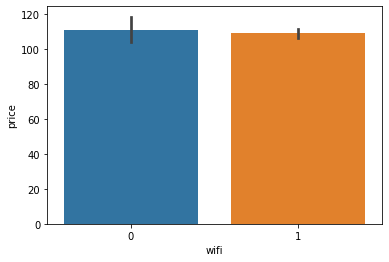

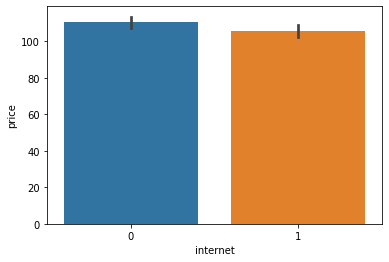

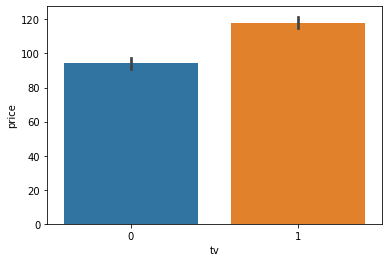

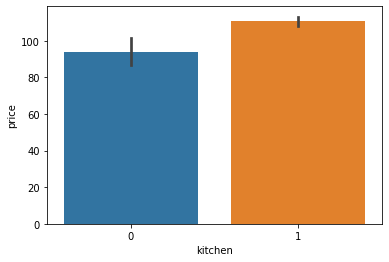

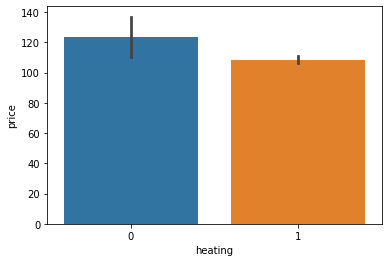

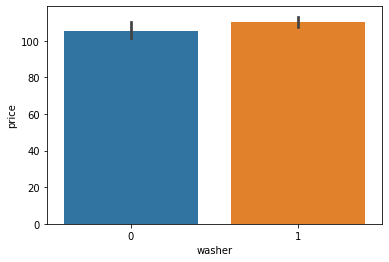

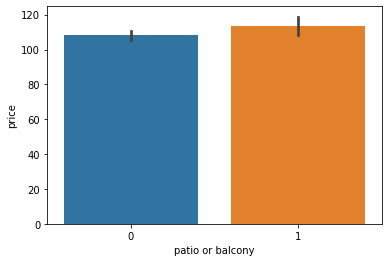

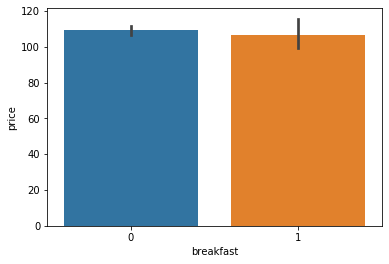

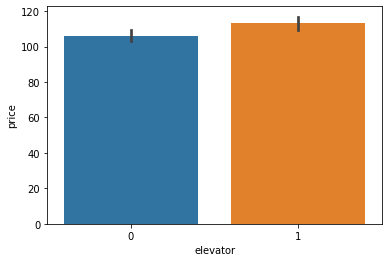

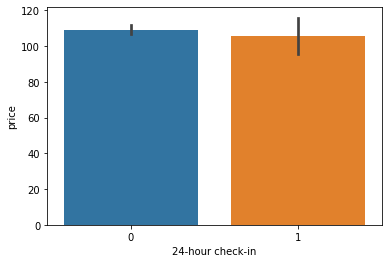

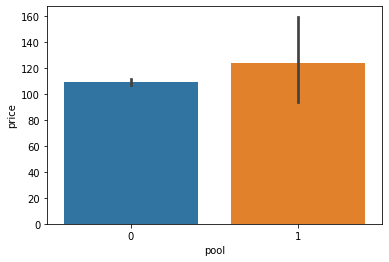

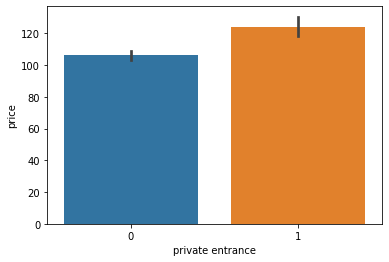

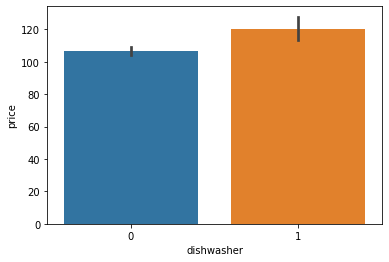

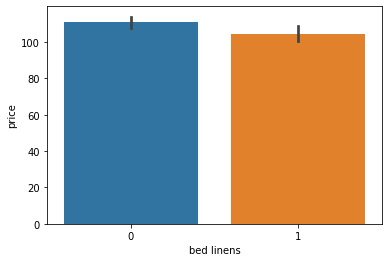

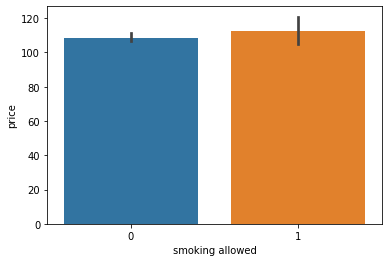

In [73]:
#Visualize
for amenity in relevant_amenities: #analyse features with regard to districts
    sns.barplot(x= munich[amenity.lower()], y='price', data=munich)
    plt.show()

In [74]:
#merge information from variables wifi and internet in the feature 'internet'
for row in munich.itertuples():
        if row.wifi == 1:
            munich.loc[row.Index, 'internet'] = 1

munich = munich.drop(columns = ['wifi', 'pool', 'bed linens'])
munich['internet'].describe()

count    10238.000000
mean         0.941883
std          0.233976
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: internet, dtype: float64

The features 'internet' and 'wifi' appear to be redundant. Therefore, the latter can be discarded. Furthermore, there seems to be a relatively small number of 'pools' in the data which suggests that the variable should be filtered out as well. Apart from that, it appears very likely that the infrequent occurence of the feature 'bed linens' is due to hosts not giving the respective information correctly. Thus, the feature is excluded accordingly.

The visualizations of the respective amenities versus the prices of listings indicate a positive effect of the features kitchen, tv and private entrance, among others. However, these indications require verification during the actual modeling process.

### Bathrooms

The number of bathrooms, since it is considered a comfort zone for the customer, is regarded another important feature for the analysis. Here Airbnb not only differentiates the number of bathrooms, but also whether it is a shared or private bathroom, as Airbnb also allows the property to be shared with other Airbnb customers and the host. So it is possible that hosts can charge a higher price for private bathrooms, as this also increases the usable space of a guest.

In [75]:
# Drop all tuples with blank entries
#munich = munich[munich.bathrooms != None]

# replace blank entries with shared bathroom
munich.loc[munich.bathrooms == None, 'bathrooms'] = 0.5

# replace zero bathrooms with shared bathroom
munich.loc[munich.bathrooms == 0.0, 'bathrooms'] = 0.5

Columns in which no input was made are removed directly from the data set because they do not provide useful information for analysis. The value "0.5" refers to a shared bathroom, while the values "1.5" and "2.5" refer to an additional guest toilet without shower. Since apartment types such as "tent" or "campervan" have already been deleted and prices are only to be predicted for real houses, it can be assumed that there is always a bathroom for guests and the host has made a wrong entry or merely indicated not to offer a bathtub. Therefore, all entries with the value "0.0" can be raised to "0.5".

1.0     8751
1.5      844
2.0      424
0.5      113
2.5       64
3.0       17
4.0        3
3.5        3
4.5        1
7.5        1
5.5        1
38.5       1
24.0       1
Name: bathrooms, dtype: int64
             max_price
bathrooms             
0.5         104.902655
1.0         123.633756
1.5         147.395735
2.0         216.705189
2.5         268.250000
3.0         448.764706
3.5         132.666667
4.0         151.666667
4.5         480.000000
5.5          29.000000
7.5          60.000000
24.0       1840.000000
38.5         70.000000


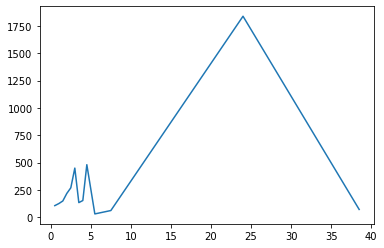

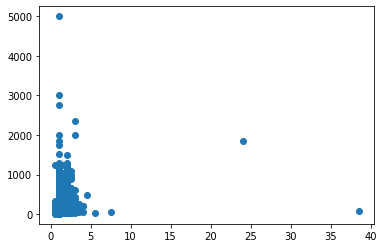

In [76]:
# check the value count
print(munich['bathrooms'].value_counts())

# analyze the effect of bathrooms on price
bathroom_price = munich[['bathrooms', 'max_price']].groupby('bathrooms').mean()

# print the mean values for bathrooms
print(bathroom_price)

# plot the effect of bathrooms on price
plt.plot(bathroom_price)

# print the plot
plt.show()

#Create a scatterplot of Price on Bathrooms
plt.scatter(munich['bathrooms'], munich['max_price'])

plt.show()

In considering the number of bathrooms in the offers as well as the ratio between the number of bathrooms and the price of the real estate, there are some things that attract attention. Firstly, most of the apartments offered on Airbnb have their own bathroom for the guests. Only with greater distance follow other types of apartments. Secondly, the effect of the number of bathrooms on the house price is almost linear, with the exception that the price increase between apartments with "1.0" and "1.5" bathrooms is lower than between "1.5" and "2.0" bathrooms.

### Accommodates

Another feature to be included in the analysis is the number of people who can be accommodated in the home. Since the number of square metres is not included in the analysis because too few entries are offered for a prediction, both the number of accommodations and the number of beds can be used to estimate the size of the accommodation.

2     5344
4     1615
1     1243
3     1242
6      288
5      270
8      101
7       54
10      26
16      18
9       17
12      10
11       4
13       3
14       2
15       1
Name: accommodates, dtype: int64
                max_price
accommodates             
1               62.902655
2               96.630240
3              133.893720
4              189.108978
5              239.151852
6              329.326389
7              377.518519
8              399.099010
9              443.470588
10             597.115385
11             542.250000
12             780.400000
13             743.333333
14            1479.500000
15             900.000000
16             795.777778


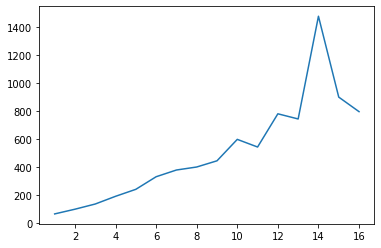

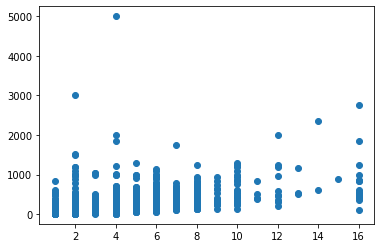

In [77]:
# check the value count
print(munich['accommodates'].value_counts())

# analyze the effect of accommodates on price
accommodates_price = munich[['accommodates', 'max_price']].groupby('accommodates').mean()

# print the mean values for accommodates
print(accommodates_price)

# print the plot
plt.plot(accommodates_price)

plt.show()

#Create a scatterplot of Price on Accommodates
plt.scatter(munich['accommodates'], munich['max_price'])

plt.show()


### Property_type

In [78]:
property_types = munich['property_type'].unique()
res = munich[munich.max_price < 0]
for i in property_types:
    tmp = munich[munich.property_type == i]
    tmp_mean = np.mean(tmp['max_price'])
    tmp_std = np.std(tmp['max_price'])
    tmp = tmp[tmp['max_price'] <= (tmp_mean + (2 * tmp_std))]
    tmp = tmp[tmp['max_price'] >= (tmp_mean - (2 * tmp_std))]
    res = pd.concat([res, tmp])
prop_pre = res

# todo: modify munich df and drop hostels

### Room_type

In [79]:
room_types = munich['room_type'].unique()
res = munich[munich.max_price < 0]
for i in room_types:
    tmp = prop_pre[prop_pre.room_type == i]
    tmp_mean = np.mean(tmp['max_price'])
    tmp_std = np.std(tmp['max_price'])
    tmp = tmp[tmp['max_price'] <= (tmp_mean + (2 * tmp_std))]
    tmp = tmp[tmp['max_price'] >= (tmp_mean - (2 * tmp_std))]
    res = pd.concat([res, tmp])
    
# todo: modify munich df

## Train-Test-Split and final Preprocessing on Training Data

In [80]:
munich.head()

,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,kitchen,heating,washer,patio or balcony,breakfast,elevator,24-hour check-in,private entrance,dishwasher,smoking allowed
0,Ludwigsvorstadt-Isarvorstadt,48.13057,11.56929,Apartment,Entire home/apt,2,1.0,1.0,1.0,1,...,1,1,1,0,0,0,0,0,0,0
1,Hadern,48.11476,11.48782,Apartment,Entire home/apt,2,1.0,1.0,1.0,3,...,1,1,0,1,0,0,0,0,1,0
2,Berg am Laim,48.11923,11.63726,Apartment,Entire home/apt,5,1.0,1.0,3.0,3,...,1,1,1,1,0,0,1,0,0,0
3,Maxvorstadt,48.15198,11.56486,Apartment,Entire home/apt,4,1.0,1.0,1.0,3,...,1,1,1,1,1,1,0,0,0,0
4,Pasing-Obermenzing,48.13898,11.46612,Apartment,Entire home/apt,4,1.0,1.0,1.0,3,...,1,1,1,0,0,0,0,0,0,1


In [81]:
# todo: delete 'neighbourhood_cleansed', 'property_type', 'room_type' once preprocessed
# drop unused features
munich = munich.drop(columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'price', 'latitude', 'longitude'])

In [82]:
# divide label from features
y = munich['max_price']
x = munich.drop('max_price', axis=1)

# normailze feature values
x_normalized = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x), columns=x.columns)

# split dataset into training and test data
xTrain, xTest, yTrain, yTest = train_test_split(x_normalized, y, test_size = 0.2, random_state = 0)

# todo: outlier detection on xTrain and yTrain
#price_std = np.std(munich['max_price'])
#price_mean = np.mean(munich['max_price'])
#print("Listings that qualify as outliers (using Standard Deviation):")
#print(munich[munich['max_price'] > (price_mean + (3*price_std))]['max_price'].count())
#munich = munich[munich['max_price'] <= (price_mean + (3*price_std))]

In [83]:
xTrain.head()

,accommodates,bathrooms,bedrooms,beds,bed_type,internet,tv,kitchen,heating,washer,patio or balcony,breakfast,elevator,24-hour check-in,private entrance,dishwasher,smoking allowed
3991,0.133333,0.013158,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
185,0.200000,0.013158,0.041667,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4794,0.200000,0.013158,0.000000,0.020408,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5048,0.066667,0.013158,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1733,0.000000,0.013158,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Initial preprocessing of Property Type & Room Type

In [25]:
label_encoder = preprocessing.LabelEncoder()
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, SelectFwe
from sklearn.svm import SVR
from collections import Counter
from sklearn.model_selection import train_test_split

# Property Type
property_types = munich['property_type'].unique()
res = munich[munich.max_price < 0]
for i in property_types:
    tmp = munich[munich.property_type == i]
    tmp_mean = np.mean(tmp['max_price'])
    tmp_std = np.std(tmp['max_price'])
    tmp = tmp[tmp['max_price'] <= (tmp_mean + (2 * tmp_std))]
    tmp = tmp[tmp['max_price'] >= (tmp_mean - (2 * tmp_std))]
    res = pd.concat([res, tmp])
prop_pre = res

# Room Type
room_types = munich['room_type'].unique()
res = munich[munich.max_price < 0]
for i in room_types:
    tmp = prop_pre[prop_pre.room_type == i]
    tmp_mean = np.mean(tmp['max_price'])
    tmp_std = np.std(tmp['max_price'])
    tmp = tmp[tmp['max_price'] <= (tmp_mean + (2 * tmp_std))]
    tmp = tmp[tmp['max_price'] >= (tmp_mean - (2 * tmp_std))]
    res = pd.concat([res, tmp])
  
# Train and evaluate SVM
# Separate features and labels
y = res['max_price']
x = res.loc[:, munich.columns.intersection(['property_type',
                                            'room_type',
                                            'accommodates'
])]

# Transform features
x['property_type'] = label_encoder.fit_transform(x['property_type'])
x['room_type'] = label_encoder.fit_transform(x['room_type'])

# Split dataset into training and test data
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 0)
print("start training now")

# Train support vector regressor
regressor = SVR(kernel='rbf')
regressor.fit(xTrain, yTrain)
print("done training")

# Predict price for training data
price_train_mean = np.mean(yTrain)
price_pred = [0] * len(xTrain)
count = -1
for index, row in xTrain.iterrows():
    count += 1
    price_pred[count] = regressor.predict([[row[0], row[1], row[2]]])[0]
rss = 0
ess = 0
count = -1
for item in yTrain.iteritems():
    count += 1
    rss = rss + pow((price_pred[count] - item[1]), 2)
    ess = ess + pow((item[1] - price_train_mean), 2)
RMSE_train = sqrt(rss/count)
r2_train = ess/(rss+ess)

print("Training RMSE: " + str(RMSE_train))
print("Training R2: " + str(r2_train))

# Predict price for test data
price_test_mean = np.mean(yTest)
price_pred = [0] * len(xTest)
count = -1
for index, row in xTest.iterrows():
    count += 1
    price_pred[count] = regressor.predict([[row[0], row[1] , row[2]]])[0]
rss = 0
ess = 0
count = -1
for item in yTest.iteritems():
    count += 1
    rss = rss + pow((price_pred[count] - item[1]), 2)
    ess = ess + pow((item[1] - price_test_mean), 2)
RMSE_test = sqrt(rss/count)
r2_test = ess/(rss+ess)

print("Test RMSE: " + str(RMSE_test))
print("Test R2: " + str(r2_test))

start training now


C:\Users\fn8j\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done training
Training RMSE: 45.24595417336327
Training R2: 0.5714482163939587
Test RMSE: 46.18665838544324
Test R2: 0.5553400001646789


## Compare different months

In [ ]:
munich_09 = pd.read_csv('Data/listings_19_09.csv')
munich_09['price'] = munich_09['price'].replace( '[\$,)]','', regex=True ).astype(float)
munich_08 = pd.read_csv('Data/listings_19_08.csv')
munich_06 = pd.read_csv('Data/listings_19_06.csv')
munich_05 = pd.read_csv('Data/listings_19_05.csv')

In [ ]:
print('May')
print('Median: ', munich_05['price'].median())
print('Mean: ', munich_05['price'].mean())
print()
print('June')
print('Median: ', munich_06['price'].median())
print('Mean: ', munich_06['price'].mean())
print()
print('July')
print('Median: ', munich['price'].median())
print('Mean: ', munich['price'].mean())
print()
print('August')
print('Median: ', munich_08['price'].median())
print('Mean: ', munich_08['price'].mean())
print()
print('September')
print('Median: ', munich_09['price'].median())
print('Mean: ', munich_09['price'].mean())


One can see that the average prices are quite stabile from May to August but increase a lot in September. This can be traced back to the Oktoberfest in Munich that takes place in September. We need to find a good solution for dealing with these variations. 